# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


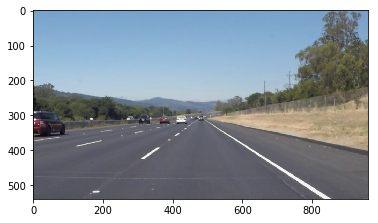

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math
from statistics import mean

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=15):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    leftLine = []
    rightLine = []
    
    leftSlope = 0
    rightSlope = 0
    x1l = 0
    x1r = 0
    x2l = 0
    x2r = 0
    totalLengthL = 0
    totalLengthR = 0
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            weight = math.hypot(x2 - x1, y2 - y1)
            if slope > 0:
                x1l += x1
                x2l += x2
                if slope > 0.3 and not math.isnan(slope):
                    totalLengthL += weight
                    leftSlope += slope*weight
                    leftLine.append(line)
            else:
                x1r += x1
                x2r += x2
                if slope < -0.3 and not math.isnan(slope):
                    rightSlope += slope*weight
                    rightLine.append(line)
                    totalLengthR += weight
                
    # Find the average slope for each side. 
    if totalLengthL != 0:
        leftSlope/=totalLengthL
    else: 
        return
    if totalLengthR != 0:
        rightSlope/=totalLengthR
    else: 
        return
    
    # Find average x values for each point
    x1l//=len(leftLine)
    x2l//=len(leftLine)
    x1r//=len(rightLine)
    x2r//=len(rightLine)
    
    #(y-y') =M(x-x')
    #(540 - 315) = slope(x - 485)  <--- 485 is the horizon point
    #225 = leftSlope*x - slope*485
    #leftSlope*x = - slope*485 - 225
    #x = -485 (-225)/slope

    rightIntercept = 485 - int(225/rightSlope)
    leftIntercept = 485 - int(225/leftSlope)
    
    print (leftIntercept, rightIntercept)
    #now that we have the slope of the lines, we can extrapolate from the bottom of the image
    cv2.line(img, (rightIntercept, 540), (520, 335), color, thickness)
    cv2.line(img, (leftIntercept, 540), (450, 335), color, thickness)
  
    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

141 834
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


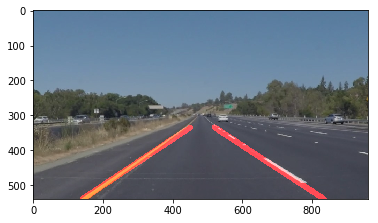

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
import numpy
import math

img = "solidYellowLeft.jpg"

#reading in an image
image = mpimg.imread('test_images/' + img)

#converting image to grayscale
gray = grayscale(image)

# Define a kernel size and apply Gaussian smoothing
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

# Define our parameters for Canny and apply
low_threshold = 200
high_threshold = 250
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# Next we'll create a masked edges image using cv2.fillPoly()
mask = np.zeros_like(edges)   
ignore_mask_color = 255   

# This time we are defining a four sided polygon to mask
imshape = image.shape
vertices = np.array([[(0,imshape[0]),(0, 0), (imshape[1], 0), (imshape[1],imshape[0])]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(edges, mask)


# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 5 # distance resolution in pixels of the Hough grid
theta = np.pi/159 # angular resolution in radians of the Hough grid
threshold = 20 # minimum number of votes (intersections in Hough grid cell)
min_line_length = 26 #minimum number of pixels making up a line
max_line_gap = 100    # maximum gap in pixels between connectable line segments

#Call Hough Lines algorithm
hough = hough_lines(edges, rho, theta, threshold, min_line_length, max_line_gap)

#defining region of interest
vertices = numpy.array([ [140, 540], [480,300], [880,540] ], numpy.int32)
#roi = region_of_interest(hough, [vertices])

result = weighted_img(hough, image, α=0.8, β=1., λ=0.)

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(result, cmap='gray')

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy

In [7]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    # TODO: Build your pipeline that will draw lane lines on the test_images
    # then save them to the test_images_output directory.

    #converting image to grayscale
    gray = grayscale(image)

    #defining region of interest
    #vertices = numpy.array([ [140, 540], [480,300], [880,540] ], numpy.int32)
    #roi = region_of_interest(gray, [vertices])g

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

    # Define our parameters for Canny and apply
    low_threshold = 200
    high_threshold = 250
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255   

    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(0, 0), (imshape[1], 0), (imshape[1],imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)


    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 5 # distance resolution in pixels of the Hough grid
    theta = np.pi/159 # angular resolution in radians of the Hough grid
    threshold = 20 # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 100 #minimum number of pixels making up a line
    max_line_gap = 50    # maximum gap in pixels between connectable line segments

    #Call Hough Lines algorithm
    hough = hough_lines(edges, rho, theta, threshold, min_line_length, max_line_gap)

    #defining region of interest
    vertices = numpy.array([ [140, 540], [480,300], [880,540] ], numpy.int32)
    #roi = region_of_interest(hough, [vertices])

    result = weighted_img(hough, image, α=0.8, β=1., λ=0.)

    return result

Let's try the one with the solid white lane on the right first ...

In [8]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

202 781
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  0%|                                                                                          | 0/222 [00:00<?, ?it/s]

202 781
185 786
223 799


  1%|█                                                                                 | 3/222 [00:00<00:07, 28.77it/s]

249 796
287 785
243 803
188 803


  3%|██▌                                                                               | 7/222 [00:00<00:06, 31.25it/s]

235 806
190 791
124 786
124 805
134 803


  5%|████▍                                                                            | 12/222 [00:00<00:06, 33.49it/s]

132 795
259 795
137 798
133 799


  7%|█████▊                                                                           | 16/222 [00:00<00:05, 34.45it/s]

137 810
129 786
136 787
139 806


  9%|███████▎                                                                         | 20/222 [00:00<00:05, 35.54it/s]

127 804
126 807
140 805
137 794


 11%|█████████                                                                        | 25/222 [00:00<00:05, 37.24it/s]

137 796
136 798
137 622
139 805
139 785


 14%|██████████▉                                                                      | 30/222 [00:00<00:05, 37.40it/s]

137 798
137 590
137 802


 15%|████████████▍                                                                    | 34/222 [00:00<00:05, 37.36it/s]

140 807
137 793
129 782
130 795


 17%|█████████████▊                                                                   | 38/222 [00:01<00:04, 37.34it/s]

142 786
138 799
141 791
137 801


 19%|███████████████▎                                                                 | 42/222 [00:01<00:04, 37.32it/s]

141 666
133 795
139 785
129 793


 21%|█████████████████▏                                                               | 47/222 [00:01<00:05, 30.91it/s]

142 792
135 798
127 792
138 761
127 803


 23%|██████████████████▉                                                              | 52/222 [00:01<00:05, 31.76it/s]

134 803
129 833
130 799
136 812


 25%|████████████████████▍                                                            | 56/222 [00:01<00:06, 24.48it/s]

157 821
122 828
130 808


 27%|█████████████████████▌                                                           | 59/222 [00:01<00:06, 23.29it/s]

137 815
134 808
137 835
136 832


 28%|██████████████████████▉                                                          | 63/222 [00:02<00:06, 23.76it/s]

145 812
138 822


 30%|████████████████████████                                                         | 66/222 [00:02<00:06, 23.31it/s]

139 729
145 821
136 806


 31%|█████████████████████████▏                                                       | 69/222 [00:02<00:06, 22.29it/s]

136 812
139 850
149 856


 32%|██████████████████████████▎                                                      | 72/222 [00:02<00:07, 21.08it/s]

138 829
136 849
136 819


 34%|███████████████████████████▎                                                     | 75/222 [00:02<00:07, 19.13it/s]

150 805
153 823
144 841
141 836


 36%|████████████████████████████▊                                                    | 79/222 [00:02<00:06, 21.64it/s]

145 830
145 813
143 842


 37%|█████████████████████████████▉                                                   | 82/222 [00:02<00:06, 20.58it/s]

148 827
146 833
148 830


 38%|███████████████████████████████                                                  | 85/222 [00:03<00:06, 22.25it/s]

158 840
150 835
161 823


 40%|████████████████████████████████                                                 | 88/222 [00:03<00:05, 22.89it/s]

150 817
159 833
160 835


 41%|█████████████████████████████████▏                                               | 91/222 [00:03<00:06, 21.40it/s]

147 560
167 823
166 799


 42%|██████████████████████████████████▎                                              | 94/222 [00:03<00:05, 22.86it/s]

161 855
165 824
167 816


 44%|███████████████████████████████████▍                                             | 97/222 [00:03<00:05, 22.44it/s]

165 822
171 822
163 836


 45%|████████████████████████████████████                                            | 100/222 [00:03<00:05, 24.26it/s]

165 843
165 833
167 826


 46%|█████████████████████████████████████                                           | 103/222 [00:03<00:05, 22.23it/s]

161 827
158 818


 48%|██████████████████████████████████████▏                                         | 106/222 [00:03<00:04, 23.97it/s]

158 812
159 833
167 799


 49%|███████████████████████████████████████▎                                        | 109/222 [00:04<00:05, 21.95it/s]

157 826
162 824
165 798


 50%|████████████████████████████████████████▎                                       | 112/222 [00:04<00:04, 22.77it/s]

153 813
149 839
148 826


 52%|█████████████████████████████████████████▍                                      | 115/222 [00:04<00:05, 20.88it/s]

149 827
154 832
141 825


 53%|██████████████████████████████████████████▌                                     | 118/222 [00:04<00:04, 22.50it/s]

139 799
149 816
155 819


 55%|███████████████████████████████████████████▌                                    | 121/222 [00:04<00:04, 21.43it/s]

130 812
136 816
136 820


 56%|████████████████████████████████████████████▋                                   | 124/222 [00:04<00:04, 21.10it/s]

138 803
135 811
137 830
138 806


 58%|██████████████████████████████████████████████▏                                 | 128/222 [00:05<00:04, 20.90it/s]

129 812
120 804
120 825


 59%|███████████████████████████████████████████████▏                                | 131/222 [00:05<00:04, 22.61it/s]

132 827
143 812
139 802


 60%|████████████████████████████████████████████████▎                               | 134/222 [00:05<00:03, 22.79it/s]

138 802
132 803
134 811


 62%|█████████████████████████████████████████████████▎                              | 137/222 [00:05<00:03, 22.14it/s]

129 818
121 827
136 805


 63%|██████████████████████████████████████████████████▍                             | 140/222 [00:05<00:03, 22.05it/s]

133 798
143 802
136 797


 64%|███████████████████████████████████████████████████▌                            | 143/222 [00:05<00:03, 22.69it/s]

134 805
125 791
135 799


 66%|████████████████████████████████████████████████████▌                           | 146/222 [00:05<00:03, 21.93it/s]

130 798
120 785
112 811
109 792


 68%|██████████████████████████████████████████████████████                          | 150/222 [00:06<00:03, 21.09it/s]

100 798
99 798
118 792


 69%|███████████████████████████████████████████████████████▏                        | 153/222 [00:06<00:03, 21.73it/s]

122 786
112 776
105 774


 70%|████████████████████████████████████████████████████████▏                       | 156/222 [00:06<00:03, 21.57it/s]

127 788
121 795
116 798


 72%|█████████████████████████████████████████████████████████▎                      | 159/222 [00:06<00:02, 21.47it/s]

122 791
124 790
106 785
103 813


 73%|██████████████████████████████████████████████████████████▋                     | 163/222 [00:06<00:02, 21.36it/s]

88 788
108 780
111 777


 75%|███████████████████████████████████████████████████████████▊                    | 166/222 [00:06<00:02, 21.93it/s]

104 773
104 780
111 779


 76%|████████████████████████████████████████████████████████████▉                   | 169/222 [00:06<00:02, 21.71it/s]

99 786
105 776
111 774


 77%|█████████████████████████████████████████████████████████████▉                  | 172/222 [00:07<00:02, 21.65it/s]

105 670
105 779
112 773


 79%|███████████████████████████████████████████████████████████████                 | 175/222 [00:07<00:02, 23.44it/s]

96 779
104 785
95 767


 80%|████████████████████████████████████████████████████████████████▏               | 178/222 [00:07<00:02, 21.27it/s]

106 785
91 770
95 777
92 621


 82%|█████████████████████████████████████████████████████████████████▌              | 182/222 [00:07<00:01, 21.40it/s]

105 761
95 784
110 761


 83%|██████████████████████████████████████████████████████████████████▋             | 185/222 [00:07<00:01, 23.39it/s]

112 761
128 780
101 779


 85%|███████████████████████████████████████████████████████████████████▋            | 188/222 [00:07<00:01, 20.76it/s]

104 762
94 781
93 767


 86%|████████████████████████████████████████████████████████████████████▊           | 191/222 [00:07<00:01, 22.81it/s]

94 766
105 775
103 796


 87%|█████████████████████████████████████████████████████████████████████▉          | 194/222 [00:08<00:01, 20.90it/s]

107 810
90 786
96 633


 89%|██████████████████████████████████████████████████████████████████████▉         | 197/222 [00:08<00:01, 22.77it/s]

94 773
95 786
99 761


 90%|████████████████████████████████████████████████████████████████████████        | 200/222 [00:08<00:00, 22.09it/s]

90 767
89 769
88 773


 91%|█████████████████████████████████████████████████████████████████████████▏      | 203/222 [00:08<00:00, 22.06it/s]

78 782
64 791
90 777


 93%|██████████████████████████████████████████████████████████████████████████▏     | 206/222 [00:08<00:00, 23.01it/s]

90 792
89 750
91 770


 94%|███████████████████████████████████████████████████████████████████████████▎    | 209/222 [00:08<00:00, 21.76it/s]

95 764
76 777


 95%|████████████████████████████████████████████████████████████████████████████▍   | 212/222 [00:08<00:00, 22.83it/s]

78 771
88 770
88 752


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 215/222 [00:08<00:00, 22.17it/s]

83 775


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 218/222 [00:09<00:00, 21.97it/s]

90 761
89 785
93 777


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:09<00:00, 24.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 10 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

152 845
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  0%|                                                                                          | 0/682 [00:00<?, ?it/s]

152 845
144 856
148 851
155 841


  1%|▍                                                                                 | 4/682 [00:00<00:19, 34.39it/s]

150 835
150 835
173 833
148 831


  1%|█                                                                                 | 9/682 [00:00<00:18, 36.51it/s]

150 835
143 821
144 830
155 825
133 809


  2%|█▋                                                                               | 14/682 [00:00<00:18, 37.04it/s]

137 818
130 821
129 821


  3%|██▏                                                                              | 18/682 [00:00<00:17, 37.64it/s]

172 809
135 801
135 815
144 817


  3%|██▋                                                                              | 23/682 [00:00<00:17, 38.03it/s]

139 806
146 806
116 803
124 804


  4%|███▏                                                                             | 27/682 [00:00<00:17, 37.80it/s]

119 785
129 805
134 779


  5%|███▋                                                                             | 31/682 [00:00<00:17, 38.18it/s]

144 797
130 797
138 791
122 786


  5%|████▏                                                                            | 35/682 [00:00<00:17, 37.38it/s]

127 776
124 786
104 791
120 791


  6%|████▋                                                                            | 39/682 [00:01<00:16, 37.99it/s]

125 782
117 789
124 787
126 785


  6%|█████                                                                            | 43/682 [00:01<00:17, 37.56it/s]

128 784
126 798
113 794
128 793


  7%|█████▌                                                                           | 47/682 [00:01<00:20, 30.37it/s]

119 791
110 794
130 793
108 790
116 795


  8%|██████▏                                                                          | 52/682 [00:01<00:19, 32.15it/s]

113 786
123 796
143 794


  8%|██████▋                                                                          | 56/682 [00:01<00:24, 25.59it/s]

119 793
118 786
112 792
123 798


  9%|███████▏                                                                         | 60/682 [00:01<00:25, 24.24it/s]

131 799
129 802
144 811


  9%|███████▍                                                                         | 63/682 [00:01<00:24, 24.81it/s]

118 811
425 804
109 804


 10%|███████▊                                                                         | 66/682 [00:02<00:25, 24.48it/s]

143 805


 10%|████████▏                                                                        | 69/682 [00:02<00:28, 21.86it/s]

137 796
417 804
141 804


 11%|████████▌                                                                        | 72/682 [00:02<00:27, 22.10it/s]

133 804
118 805
137 806


 11%|████████▉                                                                        | 75/682 [00:02<00:27, 22.07it/s]

127 806
123 801
120 807


 11%|█████████▎                                                                       | 78/682 [00:02<00:27, 22.00it/s]

137 808
124 807
118 805


 12%|█████████▌                                                                       | 81/682 [00:02<00:28, 21.34it/s]

150 803
158 802
136 802


 12%|█████████▉                                                                       | 84/682 [00:02<00:26, 22.25it/s]

129 801
150 800
132 804


 13%|██████████▎                                                                      | 87/682 [00:03<00:28, 21.05it/s]

135 815
128 807
131 806


 13%|██████████▋                                                                      | 90/682 [00:03<00:26, 22.18it/s]

138 808
145 811
113 805


 14%|███████████                                                                      | 93/682 [00:03<00:28, 20.62it/s]

172 808
137 808


 14%|███████████▍                                                                     | 96/682 [00:03<00:26, 22.53it/s]

143 808
143 808
138 801


 15%|███████████▊                                                                     | 99/682 [00:03<00:23, 24.34it/s]

138 805
139 816
138 806


 15%|███████████▉                                                                    | 102/682 [00:03<00:25, 22.67it/s]

137 816
129 820
144 811


 15%|████████████▎                                                                   | 105/682 [00:03<00:23, 24.27it/s]

40 816
145 813
134 822


 16%|████████████▋                                                                   | 108/682 [00:04<00:26, 21.84it/s]

144 819
144 800
139 814
130 804


 16%|█████████████▏                                                                  | 112/682 [00:04<00:26, 21.37it/s]

137 804
144 812
136 809


 17%|█████████████▍                                                                  | 115/682 [00:04<00:26, 21.65it/s]

144 814
123 814
138 814


 17%|█████████████▊                                                                  | 118/682 [00:04<00:24, 22.80it/s]

128 824
157 812


 18%|██████████████▏                                                                 | 121/682 [00:04<00:24, 22.92it/s]

156 812
136 823
138 812


 18%|██████████████▌                                                                 | 124/682 [00:04<00:25, 21.56it/s]

138 804
139 803
116 803


 19%|██████████████▉                                                                 | 127/682 [00:04<00:24, 22.52it/s]

128 808
134 805
126 813


 19%|███████████████▏                                                                | 130/682 [00:05<00:26, 20.69it/s]

114 812
140 802


 20%|███████████████▋                                                                | 134/682 [00:05<00:23, 23.79it/s]

133 804
131 804
128 805


 20%|████████████████                                                                | 137/682 [00:05<00:24, 21.85it/s]

130 806
144 812
125 808
115 804


 21%|████████████████▌                                                               | 141/682 [00:05<00:21, 24.76it/s]

129 812
122 812


 21%|████████████████▉                                                               | 144/682 [00:05<00:24, 22.42it/s]

122 803
125 797


 22%|█████████████████▏                                                              | 147/682 [00:05<00:22, 23.72it/s]

127 813
111 817
120 823


 22%|█████████████████▌                                                              | 150/682 [00:05<00:24, 21.48it/s]

129 798
117 805
113 809
116 804


 23%|██████████████████                                                              | 154/682 [00:05<00:21, 24.70it/s]

116 807
130 808


 23%|██████████████████▍                                                             | 157/682 [00:06<00:23, 22.08it/s]

97 801
119 808
128 808


 23%|██████████████████▊                                                             | 160/682 [00:06<00:22, 23.57it/s]

110 798
118 803
81 803


 24%|███████████████████                                                             | 163/682 [00:06<00:22, 23.24it/s]

102 804
94 806
119 802


 24%|███████████████████▍                                                            | 166/682 [00:06<00:22, 22.59it/s]

105 808
83 804
44 807
67 801


 25%|███████████████████▉                                                            | 170/682 [00:06<00:21, 23.92it/s]

60 804
101 792
71 805


 25%|████████████████████▎                                                           | 173/682 [00:06<00:23, 21.92it/s]

92 782
79 795
-13 790


 26%|████████████████████▋                                                           | 176/682 [00:06<00:22, 22.29it/s]

69 778
88 779
65 781


 26%|████████████████████▉                                                           | 179/682 [00:07<00:22, 22.10it/s]

55 777
25 779
75 795


 27%|█████████████████████▎                                                          | 182/682 [00:07<00:22, 22.62it/s]

54 786
46 778
78 777


 27%|█████████████████████▋                                                          | 185/682 [00:07<00:22, 21.89it/s]

59 787
80 774
29 779


 28%|██████████████████████                                                          | 188/682 [00:07<00:22, 21.92it/s]

61 777
54 778
69 777


 28%|██████████████████████▍                                                         | 191/682 [00:07<00:21, 22.64it/s]

71 781
-20 779
-12 779


 28%|██████████████████████▊                                                         | 194/682 [00:07<00:23, 20.38it/s]

16 782
52 768
84 777
89 782


 29%|███████████████████████▏                                                        | 198/682 [00:07<00:21, 22.82it/s]

78 778
36 776
70 785


 29%|███████████████████████▌                                                        | 201/682 [00:08<00:21, 22.67it/s]

96 785
85 775
80 779


 30%|███████████████████████▉                                                        | 204/682 [00:08<00:22, 21.27it/s]

87 780
86 782
103 791


 30%|████████████████████████▍                                                       | 208/682 [00:08<00:21, 21.56it/s]

84 793
99 790
93 798


 31%|████████████████████████▊                                                       | 211/682 [00:08<00:21, 22.18it/s]

60 798
105 790
95 798


 31%|█████████████████████████                                                       | 214/682 [00:08<00:23, 19.87it/s]

95 792
89 792
120 809
113 797


 32%|█████████████████████████▌                                                      | 218/682 [00:08<00:20, 22.64it/s]

68 793
104 797


 32%|█████████████████████████▉                                                      | 221/682 [00:09<00:23, 19.54it/s]

105 798
80 790
121 791
112 793


 33%|██████████████████████████▍                                                     | 225/682 [00:09<00:21, 21.44it/s]

127 798
97 786
107 790


 33%|██████████████████████████▋                                                     | 228/682 [00:09<00:22, 20.53it/s]

106 794
95 794


 34%|███████████████████████████                                                     | 231/682 [00:09<00:19, 22.62it/s]

97 803
88 803
129 806


 34%|███████████████████████████▍                                                    | 234/682 [00:09<00:20, 21.70it/s]

111 805
113 805
121 811


 35%|███████████████████████████▊                                                    | 237/682 [00:09<00:20, 22.17it/s]

94 812
118 799
112 802


 35%|████████████████████████████▏                                                   | 240/682 [00:09<00:19, 22.52it/s]

99 804
-15 802
93 803


 36%|████████████████████████████▌                                                   | 243/682 [00:10<00:18, 23.25it/s]

422 804
111 804
378 802


 36%|████████████████████████████▊                                                   | 246/682 [00:10<00:18, 23.23it/s]

93 803
129 794
468 806


 37%|█████████████████████████████▏                                                  | 249/682 [00:10<00:18, 23.55it/s]

467 801
393 801
111 806


 37%|█████████████████████████████▌                                                  | 252/682 [00:10<00:18, 23.72it/s]

92 807
99 802
104 802


 37%|█████████████████████████████▉                                                  | 255/682 [00:10<00:18, 23.50it/s]

120 792
111 796
51 786


 38%|██████████████████████████████▎                                                 | 258/682 [00:10<00:17, 23.80it/s]

119 791
92 795


 38%|██████████████████████████████▌                                                 | 261/682 [00:10<00:18, 22.81it/s]

128 791
100 798
70 796


 39%|██████████████████████████████▉                                                 | 264/682 [00:10<00:19, 20.99it/s]

102 802
77 802
86 803
115 806


 39%|███████████████████████████████▍                                                | 268/682 [00:11<00:18, 22.41it/s]

100 806
91 797
60 805


 40%|███████████████████████████████▉                                                | 272/682 [00:11<00:17, 22.79it/s]

74 801
128 814
78 806


 40%|████████████████████████████████▎                                               | 275/682 [00:11<00:17, 22.65it/s]

97 796
121 800


 41%|████████████████████████████████▌                                               | 278/682 [00:11<00:17, 23.13it/s]

100 793
93 796
109 830


 41%|████████████████████████████████▉                                               | 281/682 [00:11<00:17, 22.52it/s]

481 669
79 804


 42%|█████████████████████████████████▎                                              | 284/682 [00:11<00:16, 23.92it/s]

96 796
111 800
103 800


 42%|█████████████████████████████████▊                                              | 288/682 [00:11<00:17, 22.12it/s]

96 810
91 810
93 811


 43%|██████████████████████████████████▏                                             | 291/682 [00:12<00:16, 23.21it/s]

105 811
116 794


 43%|██████████████████████████████████▍                                             | 294/682 [00:12<00:17, 22.43it/s]

164 809
110 815
116 796
115 797


 44%|██████████████████████████████████▉                                             | 298/682 [00:12<00:15, 24.04it/s]

126 796
123 794
124 797


 44%|███████████████████████████████████▎                                            | 301/682 [00:12<00:16, 22.80it/s]

116 789
117 791
103 793


 45%|███████████████████████████████████▋                                            | 304/682 [00:12<00:16, 22.76it/s]

122 794
144 793
144 788


 45%|████████████████████████████████████                                            | 307/682 [00:12<00:15, 23.88it/s]

101 790
103 791
95 795


 45%|████████████████████████████████████▎                                           | 310/682 [00:12<00:18, 20.55it/s]

125 797
122 813
124 785


 46%|████████████████████████████████████▋                                           | 313/682 [00:13<00:16, 22.42it/s]

144 800
103 803
105 578


 46%|█████████████████████████████████████                                           | 316/682 [00:13<00:16, 22.60it/s]

131 804
111 803


 47%|█████████████████████████████████████▍                                          | 319/682 [00:13<00:15, 22.88it/s]

117 807
144 645
104 807


 47%|█████████████████████████████████████▊                                          | 322/682 [00:13<00:14, 24.32it/s]

105 793
117 796
119 798


 48%|██████████████████████████████████████                                          | 325/682 [00:13<00:16, 22.21it/s]

144 791
128 808
121 811
115 573


 48%|██████████████████████████████████████▌                                         | 329/682 [00:13<00:15, 22.46it/s]

122 806
128 802
131 805


 49%|██████████████████████████████████████▉                                         | 332/682 [00:13<00:15, 21.92it/s]

132 802
105 810
111 805


 49%|███████████████████████████████████████▎                                        | 335/682 [00:14<00:15, 21.95it/s]

121 808
124 818
125 811


 50%|███████████████████████████████████████▋                                        | 338/682 [00:14<00:15, 22.77it/s]

118 806
126 819
123 805
129 818


 50%|████████████████████████████████████████                                        | 342/682 [00:14<00:13, 24.95it/s]

130 817
131 817
136 816


 51%|████████████████████████████████████████▍                                       | 345/682 [00:14<00:15, 22.22it/s]

132 814
146 805
126 807


 51%|████████████████████████████████████████▊                                       | 348/682 [00:14<00:14, 23.03it/s]

117 810
120 804
118 802


 51%|█████████████████████████████████████████▏                                      | 351/682 [00:14<00:14, 22.61it/s]

112 816
127 804
132 803


 52%|█████████████████████████████████████████▌                                      | 354/682 [00:14<00:14, 21.93it/s]

131 804
128 812


 52%|█████████████████████████████████████████▉                                      | 357/682 [00:14<00:14, 22.54it/s]

121 804
120 819
106 819


 53%|██████████████████████████████████████████▏                                     | 360/682 [00:15<00:13, 23.65it/s]

122 819
126 812
118 808


 53%|██████████████████████████████████████████▌                                     | 363/682 [00:15<00:14, 22.25it/s]

125 803
121 805
90 801


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))